# XGB

In [1]:
import os
import numpy as np
import datetime, time
from biomedical_features import Biomedical_Features
from multitask_features_ECG import Multitask_Features_ECG
from multitask_features import Multitask_Features
from Preprocess import Preprocess
from classifiers.Perceptron import Perceptron
from classifiers.RandomForest import RandomForest
from classifiers.RandomForest1 import RandomForest1
from classifiers.SVM import SVM
from classifiers.NeuralNetwork import NeuralNetwork
#from classifiers.Deep_learning_CUDA0 import Deep_learning_CUDA0
from classifiers.LinearSVC import LSVC
from classifiers.RBFSVM import RBFSVM
from classifiers.LR import  LR
from classifiers.Adaboost import AdaBoost
from classifiers.kNN import kNN
from classifiers.XGBoost2 import XGBoost2
from classifiers.XGBoost1 import XGBoost1
from classifiers.XGBoost import XGBoost
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
#import tabnet
from sklearn.model_selection import StratifiedKFold
#from tabnet import TabNetClassifier

In [2]:
mainly_ecg = True
sc = 1
ecg = 1
emg = 0
#level = 3   # select the pain level(1-4)
method = 'TabNet'  # RandomForest, AdaBoost
preprocess = False

# preprocessing and classification
path = 'data/Part_A/biosignals_filtered/*/' #Part_A_sp
# original data
less_features = 2
less = True
level = 4

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def origin_data(path, less, level=4, sc=0, ecg=0, emg=0, less_features=2):
    """get the original data according to the feature(s)"""
    if less_features == 1:
        data_manage = Multitask_Features(path)
        BL_X, BL_y, PA1_X, PA1_y, PA2_X, PA2_y, PA3_X, PA3_y, PA4_X, PA4_y = \
            data_manage.extract2features(less, sc, ecg)
    elif less_features == 2:
        data_manage = Multitask_Features_ECG(path)
        BL_X, BL_y, PA1_X, PA1_y, PA2_X, PA2_y, PA3_X, PA3_y, PA4_X, PA4_y = \
            data_manage.extract2features(less, sc, ecg)
    else:
        data_manage = Biomedical_Features(path)
        BL_X, BL_y, PA1_X, PA1_y, PA2_X, PA2_y, PA3_X, PA3_y, PA4_X, PA4_y = \
                data_manage.extract2features(sc, ecg)
    if level == 4:
        X_train = np.concatenate((BL_X, PA4_X), axis=0)
        y_train = np.concatenate((BL_y, PA4_y), axis=0)
    elif level == 3:
        X_train = np.concatenate((BL_X, PA3_X), axis=0)
        y_train = np.concatenate((BL_y, PA3_y), axis=0)
    elif level == 2:
        X_train = np.concatenate((BL_X, PA2_X), axis=0)
        y_train = np.concatenate((BL_y, PA2_y), axis=0)
    else:
        X_train = np.concatenate((BL_X, PA1_X), axis=0)
        y_train = np.concatenate((BL_y, PA1_y), axis=0)
    # Decrease the dimension of x
    decrease = False
    if decrease and decrease[0]:
        tmp_x = Preprocess(X_train)
        if decrease[1] == 'NMF':
            X_train = tmp_x.NMF(decrease[2])
        elif decrease[1] == 'SVD':
            X_train = tmp_x.SVD(decrease[2])
        else:
            X_train = tmp_x.PCA(decrease[2])
    X_train, y_train = unison_shuffled_copies(X_train, y_train) #X_train.shape=(3480,83) y_train.shape=3480
    content = 'origin data'
    content += "\n The shape of X_train is {}".format(X_train.shape)
    content += '\n BL VS PA{} \n'.format(level)
    if sc:
        content += ' gsr '
    if ecg:
        content += ' ecg '
    if emg:
        content += ' emg '
    print(content)
    return X_train, y_train, content

def classification_method(method, X_train, y_train, result_name, level, sc, ecg):
    classifier = None
    if method == 'Perceptron':
        classifier = Perceptron()
    elif method == 'RF':
        classifier = RandomForest(result_name, level , sc, ecg)
    elif method == 'RF1':
        classifier = RandomForest1(result_name)
    elif method == 'XGB': # Traditional k-fold cv
        classifier = XGBoost(result_name)
    elif method == 'XGB1':
        classifier = XGBoost1(result_name)
    elif method == 'XGB2':
        classifier = XGBoost2(result_name)
    elif method == 'TabNet':
        classifer = Tabnet(result_name)
    elif method == 'SVM':
        classifier = SVM()
    elif method == 'AdaBoost':
        classifier = AdaBoost(result_name, level , sc, ecg)
    elif method == 'kNN':
        classifier = kNN(result_name)
    elif method == 'NN':
        classifier = NeuralNetwork()

    elif method == 'LinearSVC':
        classifier = LSVC(result_name)
    elif method == 'RBFSVM':
        classifier = RBFSVM(result_name)
    elif method == 'LR':
        classifier = LR(result_name)
    elif method == 'LSTM' or method == 'RNN':
        #lstm = Deep_learning_CUDA0(result_name)
        # lstm.train_LSTM_withoutK(X_train, y_train, method, 100, 2, 1)
        #lstm.train_LSTM_withK(X_train, y_train, method, 20, 100, 10, 1)
        # lstm = Deep_learning(result_name)
        # lstm.train_LSTM_withoutK(X_train, y_train, 30, 3, 1)   # num_epochs=20, input_dim=3, layer=1
        return
    classifier.cross_validation(X_train, y_train)

In [4]:
# X_train, y_train are the X features and y labels
X_train, y_train, content = origin_data(path, less, level, sc, ecg, emg, less_features)

# create a file to record the information of 5 classes
today = datetime.datetime.today().strftime('%Y-%m-%d')
result_name = today + "_result.txt"
mode = 'a' if os.path.exists(result_name) else 'w'
content += '\n The classification method is {}'.format(method)
with open(result_name, mode) as result_file:
    result_file.write("************START************\n")
    result_file.write(content + "\n")
result_file.close()
feature_file_name = ''
if less_features:
    feature_file_name = 'less'

There are files: 8700 in folder: data/Part_A/biosignals_filtered/*/
origin data
 The shape of X_train is (3480, 30)
 BL VS PA4 
 gsr  ecg 


In [6]:
from sklearn.metrics import roc_auc_score
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
CV_score_array = []
valid_auc_l = []

for train_ind, test_ind in kf.split(X_train, y_train):
    X_train_1, X_test = X_train[train_ind], X_train[test_ind]
    y_train_1, y_test = y_train[train_ind], y_train[test_ind]
    clf_xgb = XGBClassifier(max_depth=3,
    learning_rate=0.01,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

    clf_xgb.fit(X_train_1, y_train_1,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=20,
            verbose=10)
    preds = np.array(clf_xgb.predict_proba(X_test))
    valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
    valid_auc_l.append(valid_auc)
    #preds = np.array(clf_xgb.predict_proba(X_test))
    #test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

[0]	validation_0-logloss:0.68884
[10]	validation_0-logloss:0.64943
[20]	validation_0-logloss:0.61684
[30]	validation_0-logloss:0.58950
[40]	validation_0-logloss:0.56598


/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[50]	validation_0-logloss:0.54615
[60]	validation_0-logloss:0.52924
[70]	validation_0-logloss:0.51499
[80]	validation_0-logloss:0.50293
[90]	validation_0-logloss:0.49207
[100]	validation_0-logloss:0.48278
[110]	validation_0-logloss:0.47458
[120]	validation_0-logloss:0.46753
[130]	validation_0-logloss:0.46160
[140]	validation_0-logloss:0.45619
[150]	validation_0-logloss:0.45113
[160]	validation_0-logloss:0.44709
[170]	validation_0-logloss:0.44360
[180]	validation_0-logloss:0.44038
[190]	validation_0-logloss:0.43760
[200]	validation_0-logloss:0.43517
[210]	validation_0-logloss:0.43300
[220]	validation_0-logloss:0.43162
[230]	validation_0-logloss:0.42975
[240]	validation_0-logloss:0.42817
[250]	validation_0-logloss:0.42758
[260]	validation_0-logloss:0.42644
[270]	validation_0-logloss:0.42511
[280]	validation_0-logloss:0.42447
[290]	validation_0-logloss:0.42376
[300]	validation_0-logloss:0.42311
[310]	validation_0-logloss:0.42266
[320]	validation_0-logloss:0.42242
[330]	validation_0-loglos

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.49861
[90]	validation_0-logloss:0.48674
[100]	validation_0-logloss:0.47582
[110]	validation_0-logloss:0.46702
[120]	validation_0-logloss:0.45885
[130]	validation_0-logloss:0.45145
[140]	validation_0-logloss:0.44489
[150]	validation_0-logloss:0.43950
[160]	validation_0-logloss:0.43465
[170]	validation_0-logloss:0.43029
[180]	validation_0-logloss:0.42601
[190]	validation_0-logloss:0.42232
[200]	validation_0-logloss:0.41931
[210]	validation_0-logloss:0.41627
[220]	validation_0-logloss:0.41350
[230]	validation_0-logloss:0.41102
[240]	validation_0-logloss:0.40892
[250]	validation_0-logloss:0.40695
[260]	validation_0-logloss:0.40503
[270]	validation_0-logloss:0.40342
[280]	validation_0-logloss:0.40191
[290]	validation_0-logloss:0.40046
[300]	validation_0-logloss:0.39931
[310]	validation_0-logloss:0.39775
[320]	validation_0-logloss:0.39689
[330]	validation_0-logloss:0.39580
[340]	validation_0-logloss:0.39464
[350]	validation_0-logloss:0.39358
[360]	validation_0-log

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.50227
[90]	validation_0-logloss:0.49122
[100]	validation_0-logloss:0.48055
[110]	validation_0-logloss:0.47135
[120]	validation_0-logloss:0.46333
[130]	validation_0-logloss:0.45604
[140]	validation_0-logloss:0.45001
[150]	validation_0-logloss:0.44399
[160]	validation_0-logloss:0.43891
[170]	validation_0-logloss:0.43381
[180]	validation_0-logloss:0.43001
[190]	validation_0-logloss:0.42613
[200]	validation_0-logloss:0.42196
[210]	validation_0-logloss:0.41893
[220]	validation_0-logloss:0.41603
[230]	validation_0-logloss:0.41314
[240]	validation_0-logloss:0.41075
[250]	validation_0-logloss:0.40849
[260]	validation_0-logloss:0.40628
[270]	validation_0-logloss:0.40451
[280]	validation_0-logloss:0.40221
[290]	validation_0-logloss:0.40074
[300]	validation_0-logloss:0.39955
[310]	validation_0-logloss:0.39774
[320]	validation_0-logloss:0.39674
[330]	validation_0-logloss:0.39550
[340]	validation_0-logloss:0.39438
[350]	validation_0-logloss:0.39340
[360]	validation_0-log

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[90]	validation_0-logloss:0.51999
[100]	validation_0-logloss:0.51192
[110]	validation_0-logloss:0.50471
[120]	validation_0-logloss:0.49864
[130]	validation_0-logloss:0.49346
[140]	validation_0-logloss:0.48853
[150]	validation_0-logloss:0.48429
[160]	validation_0-logloss:0.48058
[170]	validation_0-logloss:0.47686
[180]	validation_0-logloss:0.47370
[190]	validation_0-logloss:0.47134
[200]	validation_0-logloss:0.46888
[210]	validation_0-logloss:0.46684
[220]	validation_0-logloss:0.46518
[230]	validation_0-logloss:0.46322
[240]	validation_0-logloss:0.46108
[250]	validation_0-logloss:0.45917
[260]	validation_0-logloss:0.45798
[270]	validation_0-logloss:0.45683
[280]	validation_0-logloss:0.45536
[290]	validation_0-logloss:0.45442
[300]	validation_0-logloss:0.45345
[310]	validation_0-logloss:0.45271
[320]	validation_0-logloss:0.45194
[330]	validation_0-logloss:0.45110
[340]	validation_0-logloss:0.45026
[350]	validation_0-logloss:0.44963
[360]	validation_0-logloss:0.44885
[370]	validation_0-lo

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.51312
[90]	validation_0-logloss:0.50314
[100]	validation_0-logloss:0.49408
[110]	validation_0-logloss:0.48638
[120]	validation_0-logloss:0.47949
[130]	validation_0-logloss:0.47334
[140]	validation_0-logloss:0.46835
[150]	validation_0-logloss:0.46375
[160]	validation_0-logloss:0.45995
[170]	validation_0-logloss:0.45659
[180]	validation_0-logloss:0.45348
[190]	validation_0-logloss:0.45080
[200]	validation_0-logloss:0.44829
[210]	validation_0-logloss:0.44610
[220]	validation_0-logloss:0.44403
[230]	validation_0-logloss:0.44216
[240]	validation_0-logloss:0.44034
[250]	validation_0-logloss:0.43882
[260]	validation_0-logloss:0.43777
[270]	validation_0-logloss:0.43663
[280]	validation_0-logloss:0.43584
[290]	validation_0-logloss:0.43491
[300]	validation_0-logloss:0.43367
[310]	validation_0-logloss:0.43287
[320]	validation_0-logloss:0.43217
[330]	validation_0-logloss:0.43166
[340]	validation_0-logloss:0.43162
[350]	validation_0-logloss:0.43091
[360]	validation_0-log

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[90]	validation_0-logloss:0.48017
[100]	validation_0-logloss:0.46988
[110]	validation_0-logloss:0.46036
[120]	validation_0-logloss:0.45199
[130]	validation_0-logloss:0.44478
[140]	validation_0-logloss:0.43831
[150]	validation_0-logloss:0.43297
[160]	validation_0-logloss:0.42772
[170]	validation_0-logloss:0.42288
[180]	validation_0-logloss:0.41868
[190]	validation_0-logloss:0.41499
[200]	validation_0-logloss:0.41216
[210]	validation_0-logloss:0.40980
[220]	validation_0-logloss:0.40700
[230]	validation_0-logloss:0.40473
[240]	validation_0-logloss:0.40275
[250]	validation_0-logloss:0.40086
[260]	validation_0-logloss:0.39925
[270]	validation_0-logloss:0.39763
[280]	validation_0-logloss:0.39621
[290]	validation_0-logloss:0.39485
[300]	validation_0-logloss:0.39356
[310]	validation_0-logloss:0.39287
[320]	validation_0-logloss:0.39163
[330]	validation_0-logloss:0.39105
[340]	validation_0-logloss:0.39009
[350]	validation_0-logloss:0.38939
[360]	validation_0-logloss:0.38857
[370]	validation_0-lo

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.48533
[90]	validation_0-logloss:0.47258
[100]	validation_0-logloss:0.46147
[110]	validation_0-logloss:0.45189
[120]	validation_0-logloss:0.44339
[130]	validation_0-logloss:0.43612
[140]	validation_0-logloss:0.42929
[150]	validation_0-logloss:0.42305
[160]	validation_0-logloss:0.41767
[170]	validation_0-logloss:0.41260
[180]	validation_0-logloss:0.40849
[190]	validation_0-logloss:0.40443
[200]	validation_0-logloss:0.40157
[210]	validation_0-logloss:0.39829
[220]	validation_0-logloss:0.39597
[230]	validation_0-logloss:0.39320
[240]	validation_0-logloss:0.39075
[250]	validation_0-logloss:0.38876
[260]	validation_0-logloss:0.38713
[270]	validation_0-logloss:0.38537
[280]	validation_0-logloss:0.38357
[290]	validation_0-logloss:0.38244
[300]	validation_0-logloss:0.38135
[310]	validation_0-logloss:0.37984
[320]	validation_0-logloss:0.37923
[330]	validation_0-logloss:0.37844
[340]	validation_0-logloss:0.37758
[350]	validation_0-logloss:0.37673
[360]	validation_0-log

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[90]	validation_0-logloss:0.53044
[100]	validation_0-logloss:0.52350
[110]	validation_0-logloss:0.51755
[120]	validation_0-logloss:0.51269
[130]	validation_0-logloss:0.50813
[140]	validation_0-logloss:0.50453
[150]	validation_0-logloss:0.50156
[160]	validation_0-logloss:0.49862
[170]	validation_0-logloss:0.49670
[180]	validation_0-logloss:0.49454
[190]	validation_0-logloss:0.49307
[200]	validation_0-logloss:0.49167
[210]	validation_0-logloss:0.49018
[220]	validation_0-logloss:0.48860
[230]	validation_0-logloss:0.48726
[240]	validation_0-logloss:0.48626
[250]	validation_0-logloss:0.48594
[260]	validation_0-logloss:0.48504
[270]	validation_0-logloss:0.48452
[280]	validation_0-logloss:0.48325
[290]	validation_0-logloss:0.48281
[300]	validation_0-logloss:0.48208
[310]	validation_0-logloss:0.48152
[320]	validation_0-logloss:0.48140
[330]	validation_0-logloss:0.48075
[340]	validation_0-logloss:0.48056
[350]	validation_0-logloss:0.48023
[360]	validation_0-logloss:0.47997
[370]	validation_0-lo

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[80]	validation_0-logloss:0.50693
[90]	validation_0-logloss:0.49646
[100]	validation_0-logloss:0.48707
[110]	validation_0-logloss:0.47910
[120]	validation_0-logloss:0.47198
[130]	validation_0-logloss:0.46583
[140]	validation_0-logloss:0.46076
[150]	validation_0-logloss:0.45570
[160]	validation_0-logloss:0.45149
[170]	validation_0-logloss:0.44780
[180]	validation_0-logloss:0.44422
[190]	validation_0-logloss:0.44113
[200]	validation_0-logloss:0.43830
[210]	validation_0-logloss:0.43582
[220]	validation_0-logloss:0.43380
[230]	validation_0-logloss:0.43217
[240]	validation_0-logloss:0.43023
[250]	validation_0-logloss:0.42856
[260]	validation_0-logloss:0.42706
[270]	validation_0-logloss:0.42552
[280]	validation_0-logloss:0.42415
[290]	validation_0-logloss:0.42305
[300]	validation_0-logloss:0.42236
[310]	validation_0-logloss:0.42174
[320]	validation_0-logloss:0.42093
[330]	validation_0-logloss:0.42050
[340]	validation_0-logloss:0.41995
[350]	validation_0-logloss:0.41918
[360]	validation_0-log

/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[70]	validation_0-logloss:0.50493
[80]	validation_0-logloss:0.49251
[90]	validation_0-logloss:0.48085
[100]	validation_0-logloss:0.46992
[110]	validation_0-logloss:0.46112
[120]	validation_0-logloss:0.45308
[130]	validation_0-logloss:0.44616
[140]	validation_0-logloss:0.44013
[150]	validation_0-logloss:0.43474
[160]	validation_0-logloss:0.43015
[170]	validation_0-logloss:0.42591
[180]	validation_0-logloss:0.42208
[190]	validation_0-logloss:0.41843
[200]	validation_0-logloss:0.41554
[210]	validation_0-logloss:0.41303
[220]	validation_0-logloss:0.41068
[230]	validation_0-logloss:0.40837
[240]	validation_0-logloss:0.40642
[250]	validation_0-logloss:0.40454
[260]	validation_0-logloss:0.40250
[270]	validation_0-logloss:0.40068
[280]	validation_0-logloss:0.39907
[290]	validation_0-logloss:0.39787
[300]	validation_0-logloss:0.39723
[310]	validation_0-logloss:0.39622
[320]	validation_0-logloss:0.39531
[330]	validation_0-logloss:0.39417
[340]	validation_0-logloss:0.39337
[350]	validation_0-logl

In [7]:
np_valid = np.array(valid_auc_l)
np.mean(np_valid)

0.8953857841194344

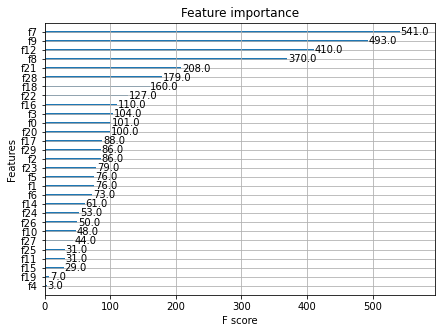

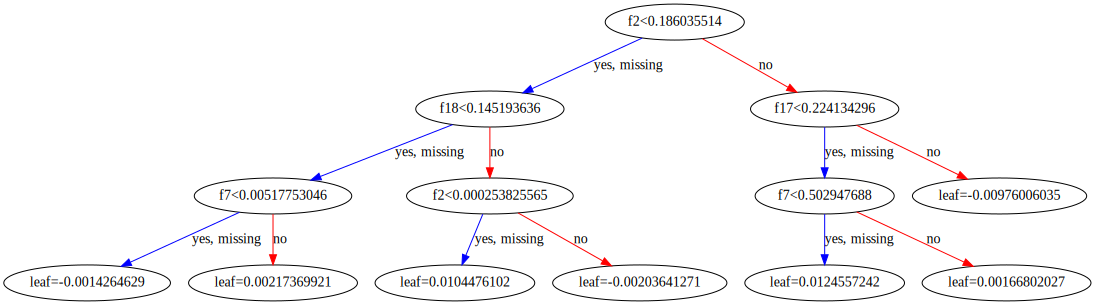

In [11]:
import graphviz
import xgboost as xgb
import matplotlib.pyplot as plt
xgb.plot_importance(clf_xgb)
plt.rcParams['figure.figsize'] = [12, 5]
plt.show()
# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(clf_xgb, num_trees=clf_xgb.best_iteration)

In [8]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=3,
    learning_rate=0.01,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=20,
        verbose=10)

[0]	validation_0-logloss:0.68881
[10]	validation_0-logloss:0.65023
[20]	validation_0-logloss:0.61789
[30]	validation_0-logloss:0.59073
[40]	validation_0-logloss:0.56714
[50]	validation_0-logloss:0.54659
[60]	validation_0-logloss:0.52908
[70]	validation_0-logloss:0.51386
[80]	validation_0-logloss:0.50040
[90]	validation_0-logloss:0.48842
[100]	validation_0-logloss:0.47782


/home/local/USHERBROOKE/shih3801/virtual/biovid_E/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[110]	validation_0-logloss:0.46868
[120]	validation_0-logloss:0.45996
[130]	validation_0-logloss:0.45223
[140]	validation_0-logloss:0.44517
[150]	validation_0-logloss:0.43893
[160]	validation_0-logloss:0.43363
[170]	validation_0-logloss:0.42884
[180]	validation_0-logloss:0.42404
[190]	validation_0-logloss:0.42018
[200]	validation_0-logloss:0.41653
[210]	validation_0-logloss:0.41304
[220]	validation_0-logloss:0.40969
[230]	validation_0-logloss:0.40651
[240]	validation_0-logloss:0.40385
[250]	validation_0-logloss:0.40119
[260]	validation_0-logloss:0.39909
[270]	validation_0-logloss:0.39664
[280]	validation_0-logloss:0.39480
[290]	validation_0-logloss:0.39301
[300]	validation_0-logloss:0.39167
[310]	validation_0-logloss:0.39049
[320]	validation_0-logloss:0.38918
[330]	validation_0-logloss:0.38825
[340]	validation_0-logloss:0.38749
[350]	validation_0-logloss:0.38679
[360]	validation_0-logloss:0.38589
[370]	validation_0-logloss:0.38526
[380]	validation_0-logloss:0.38476
[390]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=12, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, ...)

In [9]:
preds = np.array(clf_xgb.predict_proba(X_valid))
preds.shape

(348, 2)

In [10]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9121343085106384
0.8716126900198282


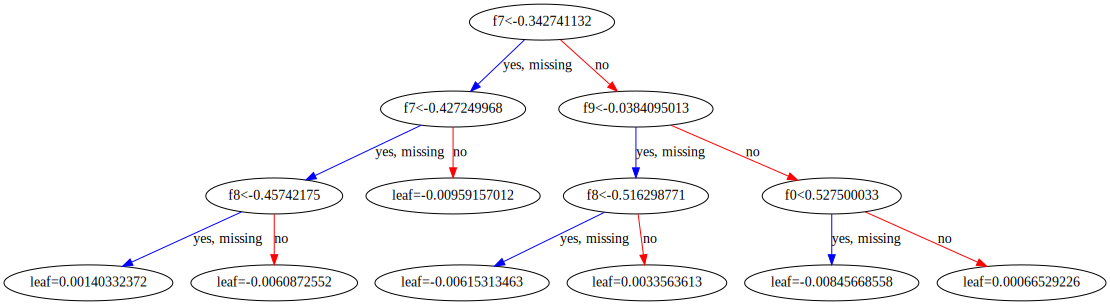

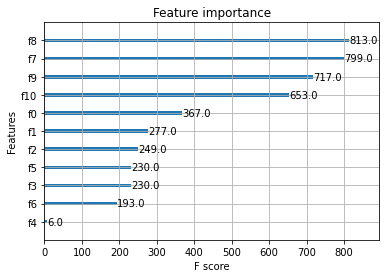

In [12]:
import graphviz
import xgboost as xgb
xgb.plot_importance(clf_xgb)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(clf_xgb, num_trees=clf_xgb.best_iteration)

In [13]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params = {"objective":"binary:logistic", "max_depth":8}
cv_res = xgb.cv(dtrain=dmatrix, params=params, nfold=10,metrics="auc",as_pandas=True, seed=None)
# Print cv_results
print(cv_res)

# Print the AUC
print((cv_res["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.931721       0.005203       0.864114      0.019979
1        0.948999       0.004227       0.872114      0.025931
2        0.959137       0.004041       0.878513      0.023022
3        0.965887       0.003142       0.880134      0.023087
4        0.970865       0.003019       0.881147      0.022422
5        0.975203       0.002562       0.881023      0.021830
6        0.978279       0.002464       0.882222      0.021445
7        0.980864       0.002334       0.882197      0.020908
8        0.983231       0.002322       0.883114      0.020355
9        0.985555       0.002058       0.883258      0.020471
0.8832579


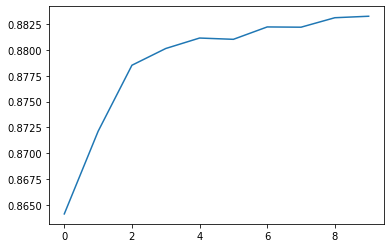

In [14]:
plt.plot(cv_res['test-auc-mean'])

In [16]:
# Perform cross-validation: cv_results
cv_results_err = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics="error", as_pandas=True, seed=None)
# Why not accuracy directly?

# Print cv_results
print(cv_results_err)
print((cv_results_err["test-error-mean"]).iloc[-1])

# Print the accuracy
print(((1-cv_results_err["test-error-mean"]).iloc[-1]))

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.127274         0.006518         0.218385        0.021991
1          0.113146         0.005288         0.207966        0.020659
2          0.103767         0.003489         0.203667        0.022446
3          0.095866         0.004672         0.203667        0.018820
4          0.088721         0.003444         0.197207        0.020736
5          0.081298         0.002188         0.201516        0.020958
6          0.076070         0.003545         0.199003        0.021974
7          0.071520         0.004617         0.201518        0.022574
8          0.066292         0.004449         0.203676        0.022302
9          0.061981         0.005122         0.200806        0.022301
0.20080590000000004
0.7991941


In [ ]:
clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
dmatrix = xgb.DMatrix(data=x_train, label=y_train)
        params = {"objective": "binary:logistic", "max_depth": 8}
        self.model = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics="auc", as_pandas=True, seed=None)
        self.model.fit(x_train, y_train,  early_stopping_rounds=40,verbose=10)

In [13]:
l = [1,2,3,4]
a = np.square(l)
a

array([ 1,  4,  9, 16])

In [14]:
np.sqrt(a)

array([1., 2., 3., 4.])

In [15]:
abs(np.ediff1d(l) / np.ediff1d(a))

array([0.33333333, 0.2       , 0.14285714])

In [3]:
r = [1, 2, 3,  5, 7, 9, 10, 12,13,16,19,22]
N = 4
win_len = int(len(r)/N)
dic= [2,5, 9]
j = 0
slope_list = []
print(win_len)
for i in range(N):
    begin = i * win_len
    end = (i + 1) * win_len -1 
    if i == N - 1:
        end = len(r) - 1
    print(begin, end)
    if dic[j] >= begin and dic[j] <= end:
        slope_list.append(dic[j])
        j += 1
    else:
        slope_list.append(0)
slope_list

3
0 2
3 5
6 8
9 11


[2, 5, 0, 9]

In [6]:
import numpy as np
l = np.array([N]+[win_len]+ [10])
l

array([ 4,  3, 10])

In [5]:
l = r + dic
l

[1, 2, 3, 5, 7, 9, 10, 12, 13, 16, 19, 22, 2, 5, 9]